In [30]:
! pip install torch --quiet
! pip install pandas --quiet
! pip install torchvision --quiet

In [31]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


# other imports
import pandas as pd
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import random

In [32]:
start_time = time.time()

# Using the inbuilt pandas function to read a dataframe from a pkl file
pokemon_df = pd.read_pickle(os.path.join('Data', 'pkl_data', 'pokemon100_2.pkl'))

end_time = time.time()

# Calculate the elapsed time
elapsed_time_seconds = end_time - start_time

elapsed_minutes = int(elapsed_time_seconds // 60)
elapsed_seconds = elapsed_time_seconds % 60

print("Elapsed Time to read the file:", elapsed_minutes, "minutes", "{:.2f}".format(elapsed_seconds), "seconds")


start_time = time.time()

Elapsed Time to read the file: 0 minutes 1.62 seconds


In [33]:
print(len(os.listdir(os.path.join('Data', 'archive', 'PokemonData'))))

149


There is 149 Pokemon in the dataset. (Missing Male and Female Nidoran)

In [34]:
print(len(pokemon_df.columns))
print(pokemon_df.columns)

150
Index(['tensor', 'pokemon_Abra', 'pokemon_Aerodactyl', 'pokemon_Alakazam',
       'pokemon_Arbok', 'pokemon_Arcanine', 'pokemon_Articuno',
       'pokemon_Beedrill', 'pokemon_Bellsprout', 'pokemon_Blastoise',
       ...
       'pokemon_Vileplume', 'pokemon_Voltorb', 'pokemon_Vulpix',
       'pokemon_Wartortle', 'pokemon_Weedle', 'pokemon_Weepinbell',
       'pokemon_Weezing', 'pokemon_Wigglytuff', 'pokemon_Zapdos',
       'pokemon_Zubat'],
      dtype='object', length=150)


In [35]:
print(pokemon_df.head(2))

                                              tensor  pokemon_Abra  \
0  [[[tensor(0.9804), tensor(0.9765), tensor(0.98...          True   
1  [[[tensor(0.4588), tensor(0.4627), tensor(0.47...          True   

   pokemon_Aerodactyl  pokemon_Alakazam  pokemon_Arbok  pokemon_Arcanine  \
0               False             False          False             False   
1               False             False          False             False   

   pokemon_Articuno  pokemon_Beedrill  pokemon_Bellsprout  pokemon_Blastoise  \
0             False             False               False              False   
1             False             False               False              False   

   ...  pokemon_Vileplume  pokemon_Voltorb  pokemon_Vulpix  pokemon_Wartortle  \
0  ...              False            False           False              False   
1  ...              False            False           False              False   

   pokemon_Weedle  pokemon_Weepinbell  pokemon_Weezing  pokemon_Wigglytuff 

In [36]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6796 entries, 0 to 6795
Columns: 150 entries, tensor to pokemon_Zubat
dtypes: bool(149), object(1)
memory usage: 1.0+ MB


In [37]:
pokemon_df.describe()

,tensor,pokemon_Abra,pokemon_Aerodactyl,pokemon_Alakazam,pokemon_Arbok,pokemon_Arcanine,pokemon_Articuno,pokemon_Beedrill,pokemon_Bellsprout,pokemon_Blastoise,...,pokemon_Vileplume,pokemon_Voltorb,pokemon_Vulpix,pokemon_Wartortle,pokemon_Weedle,pokemon_Weepinbell,pokemon_Weezing,pokemon_Wigglytuff,pokemon_Zapdos,pokemon_Zubat
count,6796,6796,6796,6796,6796,6796,6796,6796,6796,6796,...,6796,6796,6796,6796,6796,6796,6796,6796,6796,6796
unique,6796,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,"[[[tensor(0.9804), tensor(0.9765), tensor(0.98...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,1,6761,6761,6770,6755,6755,6751,6762,6756,6754,...,6740,6741,6746,6748,6747,6753,6746,6739,6744,6756


In [38]:
print(len(pokemon_df))

6796


Define the number of Pokemon from the Dataframe we want to train from.

In [39]:
pokemon_num = 10

Create a Custom Dataset for the Dataframe

In [40]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, num_pok=149):
        self.pokemon_df = dataframe
        self.num_pok = num_pok

    def __len__(self):
        pokemon_labels = []
        for index, label in enumerate(self.pokemon_df.columns):
            if index >= self.num_pok:
                break
            if label.startswith('pokemon_'):
                pokemon_labels.append(label)

        # find subset of pokemon_df where at least one of the pokemon_labels is True
        df_subset = self.pokemon_df[pokemon_df[pokemon_labels].any(axis=1)]

        return len(df_subset)
    
    def __getitem__(self, idx):

        # Extract Labels from DF
        # pokemon_labels = [label for label in self.pokemon_df.columns if label.startswith('pokemon_')]
        # pokemon_labels = ['pokemon_Charmander', 'pokemon_Squirtle', 'pokemon_Bulbasaur', 'pokemon_Pikachu']

        pokemon_labels = []
        for index, label in enumerate(self.pokemon_df.columns):
            if index >= self.num_pok:
                break
            if label.startswith('pokemon_'):
                pokemon_labels.append(label)

        # find subset of pokemon_df where at least one of the pokemon_labels is True
        df_subset = self.pokemon_df[pokemon_df[pokemon_labels].any(axis=1)]

        # Use that subset to extract data and target
        data = df_subset.loc[idx]['tensor']
        target = df_subset.loc[idx]
        target = [target[col] for col in pokemon_labels]
        target = [int(x) for x in target]
        target = torch.tensor(target)
        return data, target

# Assuming pokemon_df is your DataFrame
dataset = CustomDataset(pokemon_df, num_pok=pokemon_num)

In [41]:
print(len(dataset))

339


In [42]:
def dataset_splitter(dataset, valid_size=0.1, test_size=0.1):
    dataset_size = len(dataset)
    valid_int = int(valid_size * dataset_size)
    test_int = int(test_size * dataset_size)
    train_int = dataset_size - valid_int - test_int

    # Splitting the dataset into train and test sets
    train_set, test_and_valid_set = random_split(dataset, [train_int, test_int + valid_int])
    valid_set, test_set = random_split(test_and_valid_set, [valid_int, test_int])

    return train_set, valid_set, test_set

In [43]:
batch_size = 10

train_set, valid_set, test_set = dataset_splitter(dataset)

# Creating DataLoader for train and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        
        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, pokemon_num)
        
        # Define dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
    # Forward pass through the network
    
        # Convolutional layers with batch normalization, ReLU activation, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 12 * 12)
        
        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
net = Net().to(device)

In [45]:
num_epochs = 10
loss_hist = []
valid_loss_hist = []
valid_acc_hist = []
counter = 0
learning_rate = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = F.cross_entropy

stop = False

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output = net(data)  # net(data.view(20, -1))

        # initialize the loss & sum over time
        loss_val = loss(output, torch.argmax(targets, dim=1))
        
        # Gradient calculation + weight update
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Validaion set
        with torch.no_grad():
            net.eval()
            valid_data, valid_targets = next(iter(valid_loader))
            valid_data = valid_data.to(device)
            valid_targets = valid_targets.to(device)

            # valid set forward pass
            output = net(valid_data)

            # valid set loss
            valid_loss = loss(output, torch.argmax(valid_targets, dim=1))
            valid_loss_hist.append(valid_loss.item())

            # Validation accuracy calculation
            _, predicted = torch.max(output, 1)
            # print(predicted)
            _, valid_labels = torch.max(valid_targets, 1)
            correct = (predicted == valid_labels).sum().item()
            total = valid_targets.size(0)
            valid_accuracy = correct / total
            valid_acc_hist.append(valid_accuracy)
                                  
            # Print train/valid loss/accuracy 
            if counter % 50 == 0:
                print(f"Epoch: {epoch}")
                print(f"Loss on test set: {valid_loss.item()}")
                print(f"Accuracy on test set: {valid_accuracy}")
            counter += 1

    if stop:
        break

Epoch: 0
Loss on test set: 251.61752319335938
Accuracy on test set: 0.1
Epoch: 1
Loss on test set: 2.1627988815307617
Accuracy on test set: 0.2
Epoch: 3
Loss on test set: 2.0927023887634277
Accuracy on test set: 0.2
Epoch: 5
Loss on test set: 2.288797616958618
Accuracy on test set: 0.7
Epoch: 7
Loss on test set: 1.54823899269104
Accuracy on test set: 0.2
Epoch: 8
Loss on test set: 1.2528209686279297
Accuracy on test set: 0.6


What printing the output looks like

In [46]:
net.eval()
batch_size = train_loader.batch_size
print(batch_size)
data, targets = next(iter(train_loader))
print('data.shape:', data.shape)
output = net(data)  # net(data.view(batch_size, -1))
print(output.shape)
print(output[1])
print(output[4])
print(torch.argmax(targets, dim=1))
print(torch.argmax(targets, dim=1))

10
data.shape: torch.Size([10, 3, 100, 100])
torch.Size([10, 10])
tensor([  0.5839,   1.2942,   0.9024,   5.9996,  -2.0287,  -0.1225,   0.0803,
          2.2334,  -1.5082, -39.6281], grad_fn=<SelectBackward0>)
tensor([ -4.5998,   5.9437,  -4.4731,   0.8299,  -7.6701,   8.6001,  -0.2628,
         -4.1710,   1.0879, -53.7421], grad_fn=<SelectBackward0>)
tensor([4, 7, 5, 1, 5, 2, 3, 2, 1, 8])
tensor([4, 7, 5, 1, 5, 2, 3, 2, 1, 8])


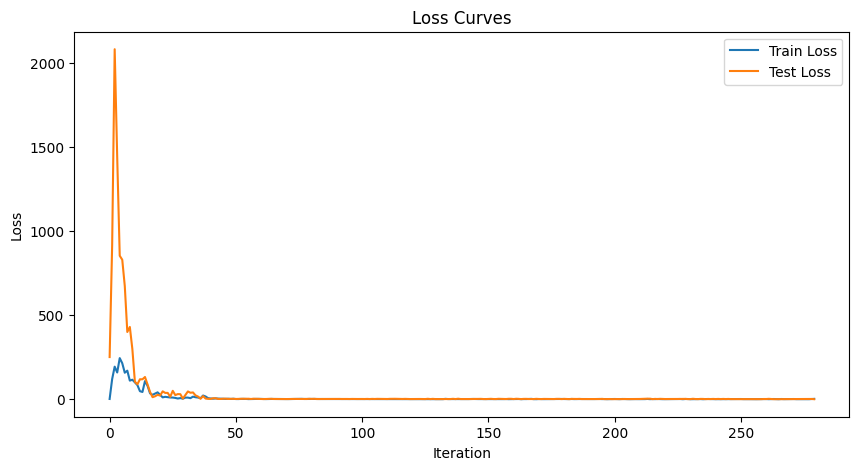

In [47]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(valid_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

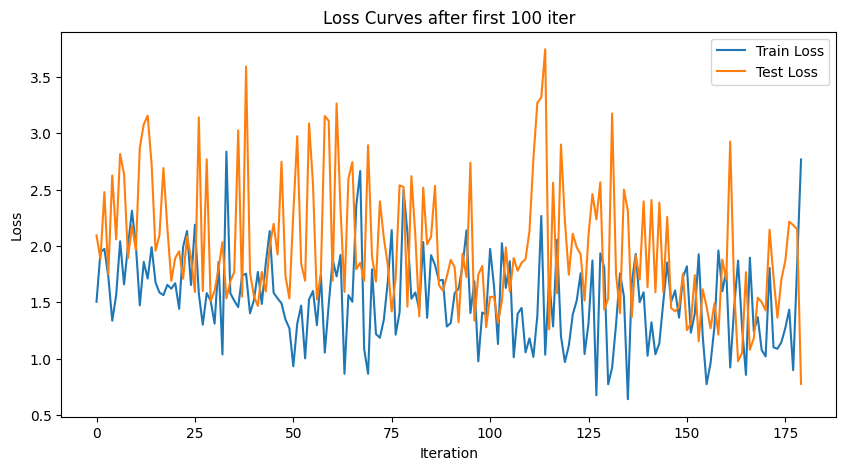

In [48]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist[100:])
plt.plot(valid_loss_hist[100:])
plt.title("Loss Curves after first 100 iter")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

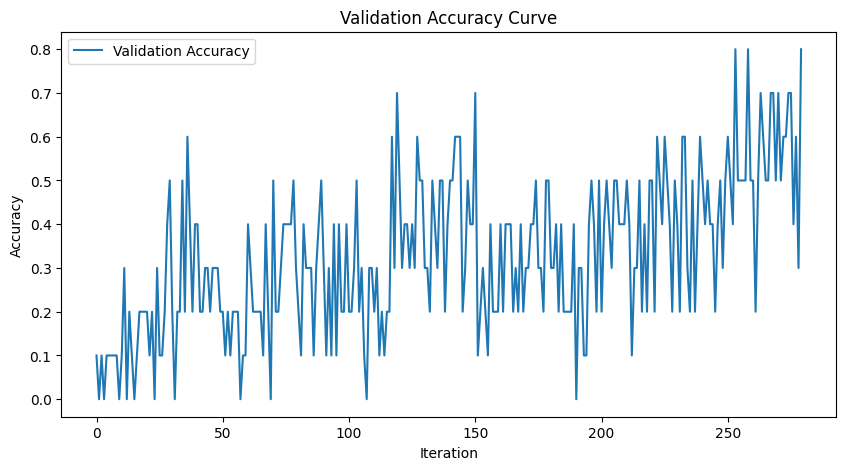

In [56]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(valid_acc_hist)
plt.title("Validation Accuracy Curve")
plt.legend(["Validation Accuracy"])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [60]:
test_loss_hist = []
test_acc_hist = []
loss = F.cross_entropy

net.eval()

# Minibatch training loop
for test_data, test_targets in iter(test_loader):
    # valid set forward pass
    output = net(test_data)

    # test set loss
    test_loss = loss(output, torch.argmax(test_targets, dim=1))
    test_loss_hist.append(test_loss.item())

    # testation accuracy calculation
    _, predicted = torch.max(output, 1)
    # print(predicted)
    _, test_labels = torch.max(test_targets, 1)
    correct = (predicted == test_labels).sum().item()
    total = test_targets.size(0)
    test_accuracy = correct / total
    test_acc_hist.append(test_accuracy)

avg_test_acc = sum(test_acc_hist)/len(test_acc_hist)
avg_test_loss = sum(test_loss_hist)/len(test_loss_hist)
print(f'The average test batch accuracy: {avg_test_acc}')
print(f'The average test batch loss: {avg_test_loss}')
                            

The average test batch accuracy: 0.6166666666666666
The average test batch loss: 1.245790258049965


In [58]:
pokemon_labels = []
for idx, label in enumerate(pokemon_df.columns):
    if idx >= pokemon_num:
        break
    if label.startswith('pokemon_'):
        pokemon_labels.append(label)

rand_label = random.choice(pokemon_labels)

# Get a random sample from the 'tensor' column from a random pokemon
random_row = pokemon_df[pokemon_df[rand_label]].sample(n=1)
random_pokemon_sample = random_row['tensor']
to_pil = transforms.ToPILImage()
random_image = to_pil(random_pokemon_sample.item())
random_image.show()

# Test it with our cnn
net.eval()
output = net(random_pokemon_sample.item().unsqueeze(0))

# Print actual label
print('Actual label:', rand_label)

# print predicted index
print('Predicted index:', torch.argmax(output).item())
print('Predicted label:', pokemon_labels[torch.argmax(output).item()])



Actual label: pokemon_Arbok
Predicted index: 3
Predicted label: pokemon_Arbok


In [52]:
valid_data, valid_targets = next(iter(valid_loader))

print(valid_targets)
# print(valid_data)

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0]])


In [53]:
train_data, train_targets = next(iter(train_loader))

print(train_targets)
print(torch.argmax(train_targets))
# print(valid_data)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]])
tensor(8)


In [65]:
# Create a Pickle file from the inbuilt dataframe.to_pickle() function
counter = 1
while True:
    file_name = str(pokemon_num) + '_' + f"{avg_test_acc*100:.0f}" + 'percent' + '_' + str(counter) + '.pth'

    # Check to make sure the file name doesn't already exist
    if file_name not in os.listdir(os.path.join('Models')):
        # Create the file and dump to it
        print('Saving Model...')
        torch.save(net.state_dict(), os.path.join('Models', file_name))
        break
    counter += 1

Saving Model...
